In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
words = [
    "Deepak",
    "Shiva",
    "Ram",
    "Vinshu",
    "Bhramha",
    "Krishna",
    "Hanuman",
    "Ganesh",
    "Zidus",
    "parashuram",
    "sitaram",
    "radheshyam",
    "fal",
    "xmen",
    "cat",
    "jamwant",
    "omkar",
    "quality",
    "bajrangbali",
    "pavansut",
    "anjaniputra",
    "sankatmochan"
]

words = [word.lower() for word in words]

words[:3]

['deepak', 'shiva', 'ram']

In [3]:
len(words)


22

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [17]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([127, 3]) torch.Size([127])
torch.Size([17, 3]) torch.Size([17])
torch.Size([28, 3]) torch.Size([28])


In [55]:
g = torch.Generator().manual_seed(1223345)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g) * 0.2
b1 = torch.randn(100, generator=g) * 0.02
W2 = torch.randn((100,27), generator=g) * 0.1
b2 = torch.randn(27, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True


In [56]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < int(max_steps/10) else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % int(max_steps/100) == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

      0/  20000: 3.3837


In [32]:
# first iteration by default random weight and bais we get loss 15 and its too high as compared to other loss

# how to get idea of loss 
# since vocab size is 27 so ideally the output can have probability of 1/27 

ideal_loss = -torch.tensor(1/27).log()
ideal_loss

tensor(3.2958)

In [33]:
# Now another example
logits = torch.tensor([0.0, 0.0,0.0,0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
loss

tensor(1.3863)

In [38]:
# lets look at logits of actual nn
logits[0] # ideally these values should be much closer to zero

tensor([ 1.6256, 10.4286,  0.9937, -2.9857, -0.1225,  3.8642,  0.9269,  3.1478,
        -0.6772,  0.0148,  0.7818,  2.2351,  2.4494,  1.5814,  6.0255,  3.5405,
         4.0033,  3.2424,  3.5393,  5.0417, -0.7692, -0.0549, -2.8504, -0.6302,
         1.2994, -1.2413,  0.1054], grad_fn=<SelectBackward0>)

In [41]:
# since logits = h @ W2 + b2 
# we can remove b2 and reduce W2 to reduce logits 
# after doing this we got initial loss 3.33 which is better

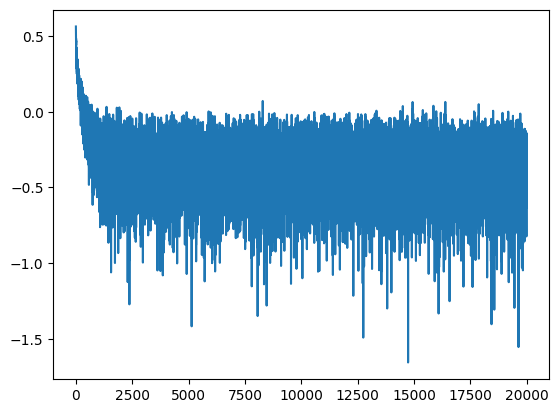

In [42]:
# loss should not be like hockey stick, this is better now
plt.plot(lossi)


In [43]:
# let us look at h
h.shape, h

(torch.Size([32, 100]),
 tensor([[ 0.9147,  0.9951, -0.9973,  ..., -0.9494, -0.9998,  0.9998],
         [ 0.1522, -0.9995, -0.0455,  ...,  0.5887,  0.9962,  0.7420],
         [-1.0000, -0.9998, -0.9859,  ...,  1.0000,  1.0000, -0.9999],
         ...,
         [ 0.7942,  0.6785, -0.9915,  ...,  0.3426, -0.9803,  0.9999],
         [ 0.9973,  0.9993, -1.0000,  ..., -0.9766, -1.0000,  1.0000],
         [-0.9126, -1.0000, -0.6183,  ...,  0.9287,  0.9917,  0.5878]],
        grad_fn=<TanhBackward0>))

(array([1020.,   87.,   66.,   45.,   25.,   37.,   20.,   18.,   26.,
          24.,   21.,   12.,   17.,   20.,    9.,    8.,   15.,   12.,
           9.,   12.,   13.,    8.,   13.,    6.,   18.,    9.,   14.,
          17.,   10.,    8.,   14.,   14.,    7.,   20.,    7.,   10.,
          15.,   17.,   16.,   20.,   16.,   32.,   18.,   29.,   36.,
          38.,   51.,   56.,   93., 1072.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

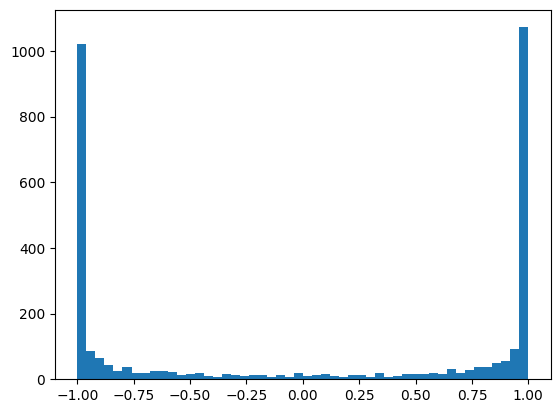

In [44]:
plt.hist(h.view(-1).tolist(), 50)

(array([  2.,   1.,   0.,   2.,   3.,   3.,   1.,   3.,  11.,   3.,  17.,
         13.,  25.,  44.,  44.,  90., 102., 109., 138., 162., 140., 176.,
        198., 197., 191., 202., 202., 197., 182., 154., 106., 118.,  93.,
         71.,  56.,  36.,  28.,  17.,  20.,  14.,   8.,   6.,   4.,   2.,
          2.,   0.,   1.,   1.,   4.,   1.]),
 array([-16.60708237, -15.92676086, -15.24643936, -14.56611786,
        -13.88579636, -13.20547485, -12.52515335, -11.84483185,
        -11.16451035, -10.48418884,  -9.80386734,  -9.12354584,
         -8.44322433,  -7.76290283,  -7.08258133,  -6.40225983,
         -5.72193832,  -5.04161682,  -4.36129532,  -3.68097382,
         -3.00065231,  -2.32033081,  -1.64000931,  -0.95968781,
         -0.2793663 ,   0.4009552 ,   1.0812767 ,   1.76159821,
          2.44191971,   3.12224121,   3.80256271,   4.48288422,
          5.16320572,   5.84352722,   6.52384872,   7.20417023,
          7.88449173,   8.56481323,   9.24513474,   9.92545624,
         10.605777

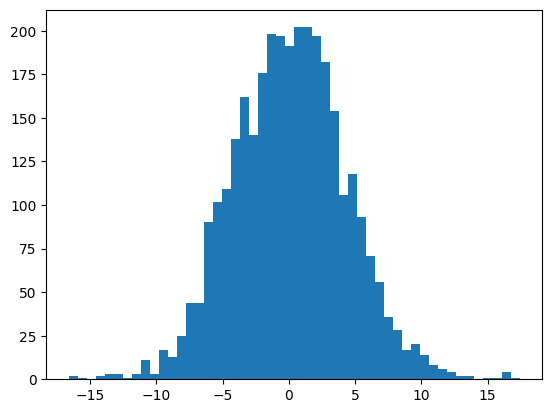

In [45]:
# above histogram of h shows that either h values are close to -1 or 1
# lets look at preactivation 
preact = emb.view(-1, 6) @ W1 + b1
plt.hist(preact.view(-1).tolist(), 50)

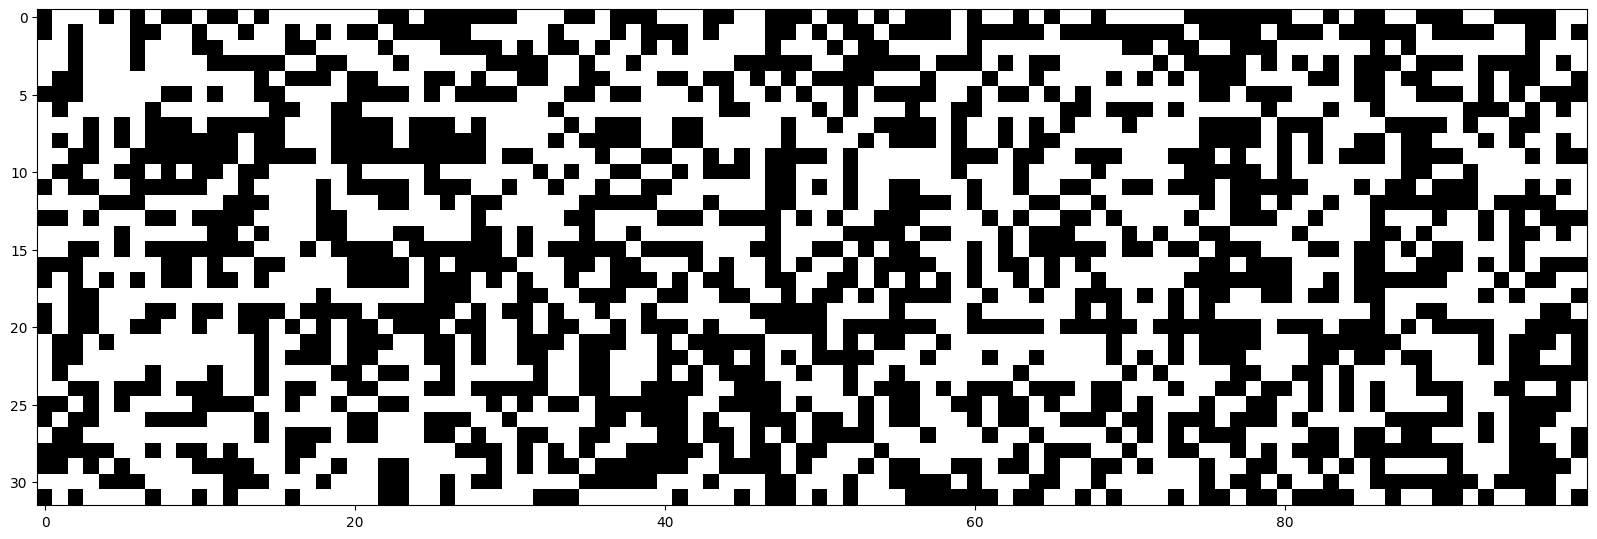

In [46]:
# This values going to tanh function, we can see it goes from -15 to 15 # not good
# lets check for dead neurons
plt.figure(figsize=(20,20))
plt.imshow(h.abs() > 0.99 , cmap="gray", interpolation="nearest")

(array([  5.,   0.,   0.,   7.,   7.,   3.,  21.,  15.,  16.,  25.,  20.,
         45.,  33.,  71.,  51., 121., 101., 110., 136., 161., 176., 182.,
        199., 234., 189., 163., 170., 159., 138., 127., 125.,  83.,  70.,
         61.,  28.,  51.,  22.,  29.,  13.,   7.,   7.,   6.,   3.,   5.,
          1.,   0.,   1.,   1.,   0.,   2.]),
 array([-0.72691143, -0.69585163, -0.66479183, -0.63373203, -0.60267223,
        -0.57161244, -0.54055264, -0.50949284, -0.47843304, -0.44737324,
        -0.41631345, -0.38525365, -0.35419385, -0.32313405, -0.29207425,
        -0.26101446, -0.22995466, -0.19889486, -0.16783506, -0.13677526,
        -0.10571547, -0.07465567, -0.04359587, -0.01253607,  0.01852373,
         0.04958352,  0.08064332,  0.11170312,  0.14276292,  0.17382272,
         0.20488251,  0.23594231,  0.26700211,  0.29806191,  0.32912171,
         0.3601815 ,  0.3912413 ,  0.4223011 ,  0.4533609 ,  0.4844207 ,
         0.51548049,  0.54654029,  0.57760009,  0.60865989,  0.63971969,
 

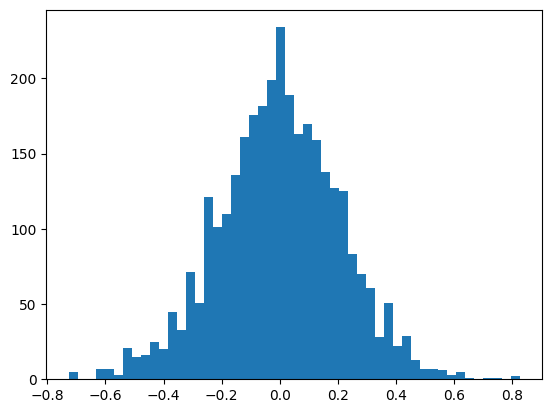

In [52]:
# if there is a complete while column means dead neuron
# we update W1 and b1
# new h
plt.hist(h.view(-1).tolist(), 50)

(array([  5.,   0.,   0.,   0.,   6.,   6.,   4.,  15.,  17.,  16.,  22.,
         26.,  45.,  49.,  82., 113., 137., 144., 210., 218., 245., 314.,
        247., 229., 208., 188., 179., 130., 101.,  71.,  33.,  53.,  27.,
         21.,  12.,   6.,   7.,   1.,   4.,   4.,   0.,   1.,   1.,   0.,
          1.,   0.,   0.,   0.,   0.,   2.]),
 array([-0.91296768, -0.87112694, -0.8292862 , -0.78744546, -0.74560472,
        -0.70376397, -0.66192323, -0.62008249, -0.57824175, -0.53640101,
        -0.49456027, -0.45271952, -0.41087878, -0.36903804, -0.3271973 ,
        -0.28535656, -0.24351582, -0.20167507, -0.15983433, -0.11799359,
        -0.07615285, -0.03431211,  0.00752863,  0.04936938,  0.09121012,
         0.13305086,  0.1748916 ,  0.21673234,  0.25857308,  0.30041383,
         0.34225457,  0.38409531,  0.42593605,  0.46777679,  0.50961753,
         0.55145828,  0.59329902,  0.63513976,  0.6769805 ,  0.71882124,
         0.76066198,  0.80250273,  0.84434347,  0.88618421,  0.92802495,
 

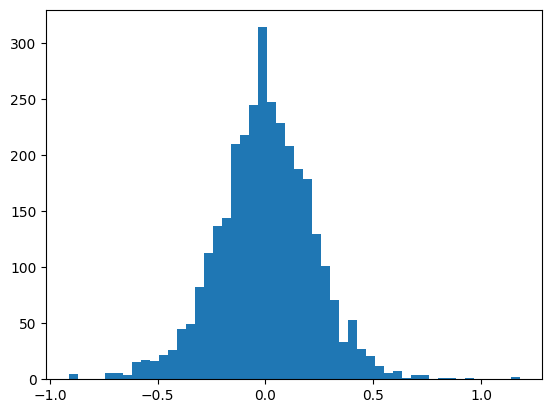

In [53]:
# lets relook at preactivation 
preact = emb.view(-1, 6) @ W1 + b1
plt.hist(preact.view(-1).tolist(), 50)

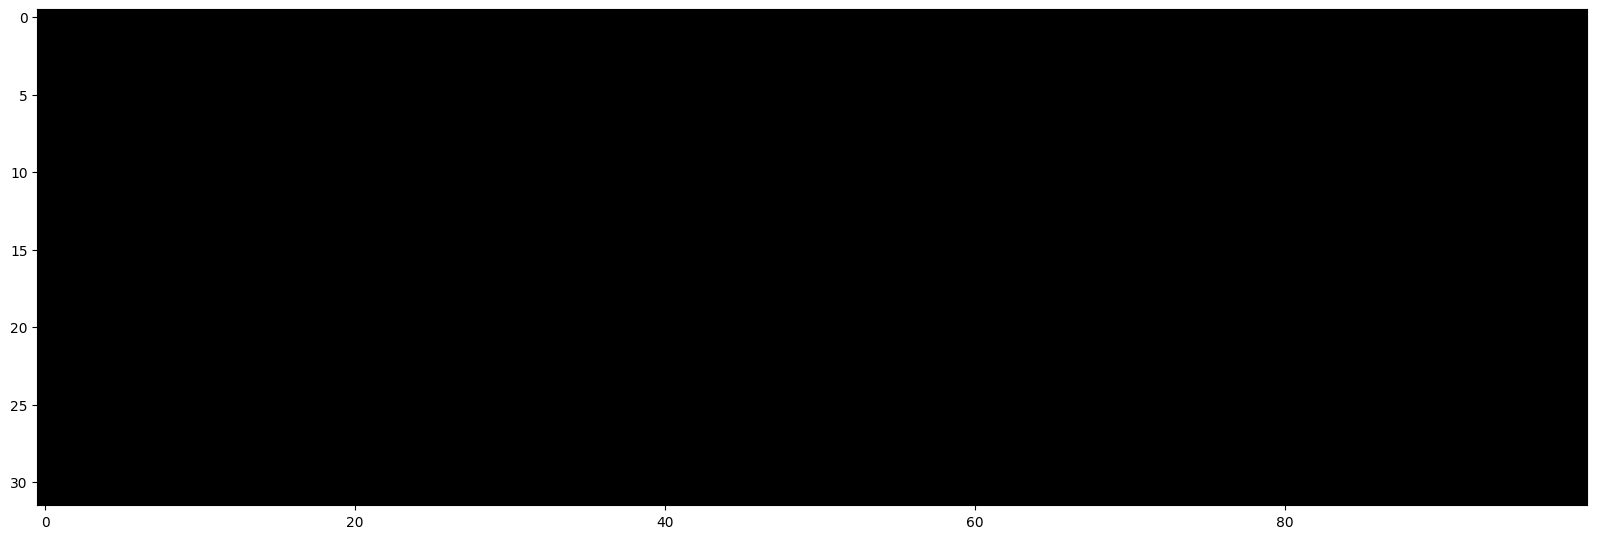

In [54]:
plt.figure(figsize=(20,20))
plt.imshow(h.abs() > 0.99 , cmap="gray", interpolation="nearest")

In [ ]:
# no white block
# means it is working ok, Now lets do that again for W1 *0.2 and b1*0.02

(array([  5.,  12.,   5.,  28.,  18.,  25.,  21.,  33.,  33.,  48.,  55.,
         38.,  89.,  78.,  75.,  72.,  83., 114.,  95., 127., 106., 112.,
        109., 132., 163., 109., 124., 109.,  96., 105., 102., 112., 106.,
         72., 100.,  82.,  71.,  60.,  51.,  51.,  24.,  38.,  32.,  32.,
         15.,  11.,   9.,   4.,   6.,   3.]),
 array([-0.95120561, -0.91254109, -0.87387656, -0.83521204, -0.79654752,
        -0.75788299, -0.71921847, -0.68055395, -0.64188942, -0.6032249 ,
        -0.56456038, -0.52589585, -0.48723133, -0.44856681, -0.40990228,
        -0.37123776, -0.33257324, -0.29390871, -0.25524419, -0.21657967,
        -0.17791514, -0.13925062, -0.1005861 , -0.06192157, -0.02325705,
         0.01540747,  0.054072  ,  0.09273652,  0.13140104,  0.17006557,
         0.20873009,  0.24739461,  0.28605914,  0.32472366,  0.36338818,
         0.40205271,  0.44071723,  0.47938175,  0.51804628,  0.5567108 ,
         0.59537532,  0.63403985,  0.67270437,  0.71136889,  0.75003342,
 

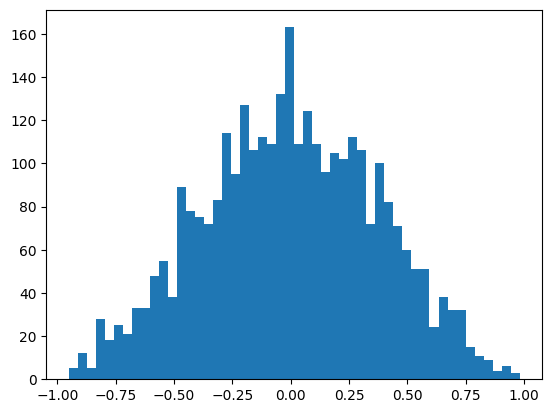

In [57]:
plt.hist(h.view(-1).tolist(), 50)

(array([  5.,   0.,   0.,   0.,   5.,   7.,   3.,  13.,  19.,  13.,  23.,
         27.,  36.,  49.,  86., 100., 138., 147., 197., 221., 242., 306.,
        266., 218., 216., 202., 172., 140.,  92.,  79.,  37.,  49.,  28.,
         24.,  10.,   8.,   8.,   1.,   3.,   5.,   0.,   1.,   1.,   0.,
          1.,   0.,   0.,   0.,   0.,   2.]),
 array([-1.83898103, -1.7551469 , -1.67131276, -1.58747863, -1.50364449,
        -1.41981035, -1.33597622, -1.25214208, -1.16830795, -1.08447381,
        -1.00063968, -0.91680554, -0.83297141, -0.74913727, -0.66530313,
        -0.581469  , -0.49763486, -0.41380073, -0.32996659, -0.24613246,
        -0.16229832, -0.07846419,  0.00536995,  0.08920408,  0.17303822,
         0.25687236,  0.34070649,  0.42454063,  0.50837476,  0.5922089 ,
         0.67604303,  0.75987717,  0.8437113 ,  0.92754544,  1.01137958,
         1.09521371,  1.17904785,  1.26288198,  1.34671612,  1.43055025,
         1.51438439,  1.59821852,  1.68205266,  1.7658868 ,  1.84972093,
 

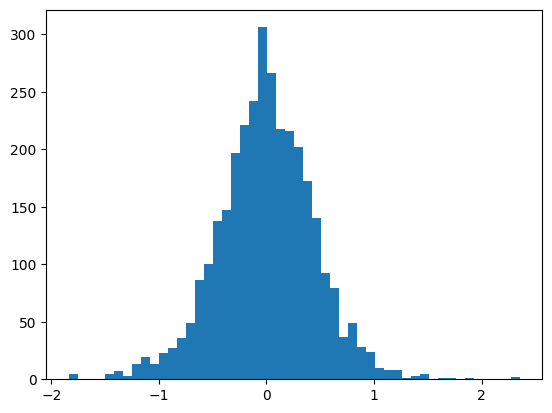

In [58]:
# lets look at preactivation 
preact = emb.view(-1, 6) @ W1 + b1
plt.hist(preact.view(-1).tolist(), 50)

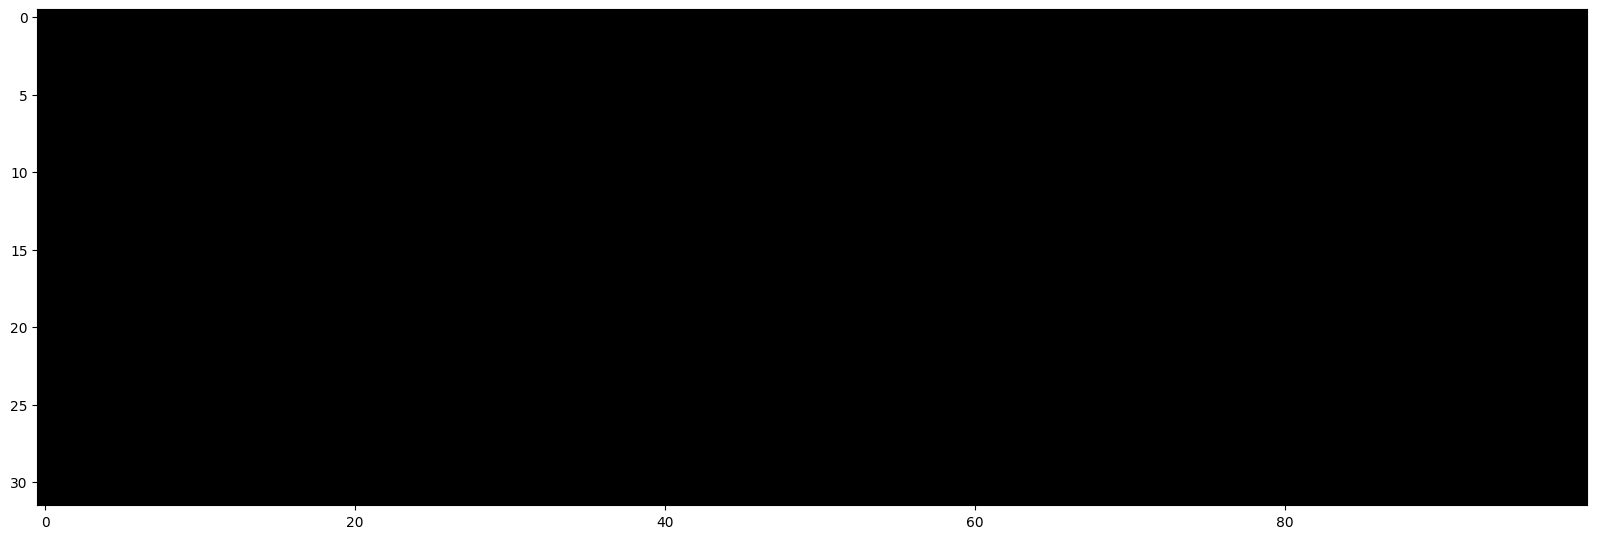

In [59]:
plt.figure(figsize=(20,20))
plt.imshow(h.abs() > 0.99 , cmap="gray", interpolation="nearest")

In [ ]:
# ideally it should show a few white blocks

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

In [19]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < int(max_steps/10) else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % int(max_steps/100) == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

      0/  20000: 3.3073


(array([164., 179., 188., 170., 161., 181., 147., 140., 112., 134., 118.,
        121., 128., 107., 109., 146., 113.,  81., 113.,  98.,  71., 114.,
        103.,  91., 101.,  92.,  99., 118., 120.,  98.,  88.,  97., 120.,
        112., 103.,  86.,  89., 126., 108., 122., 136., 134., 134., 161.,
        178., 186., 173., 197., 184., 149.]),
 array([-0.99826288, -0.95837274, -0.9184826 , -0.87859245, -0.83870231,
        -0.79881217, -0.75892203, -0.71903188, -0.67914174, -0.6392516 ,
        -0.59936146, -0.55947131, -0.51958117, -0.47969103, -0.43980088,
        -0.39991074, -0.3600206 , -0.32013046, -0.28024031, -0.24035017,
        -0.20046003, -0.16056989, -0.12067974, -0.0807896 , -0.04089946,
        -0.00100932,  0.03888083,  0.07877097,  0.11866111,  0.15855126,
         0.1984414 ,  0.23833154,  0.27822168,  0.31811183,  0.35800197,
         0.39789211,  0.43778225,  0.4776724 ,  0.51756254,  0.55745268,
         0.59734282,  0.63723297,  0.67712311,  0.71701325,  0.7569034 ,
 

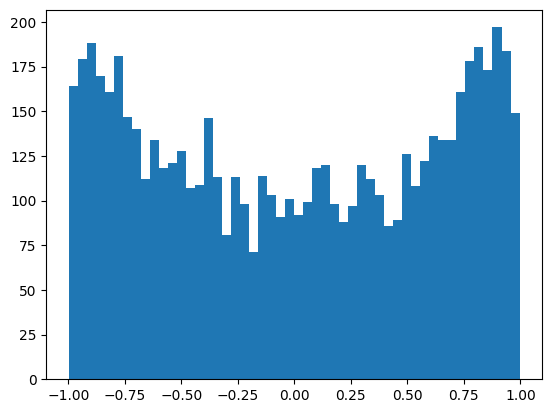

In [21]:
plt.hist(h.view(-1).tolist(), 50)

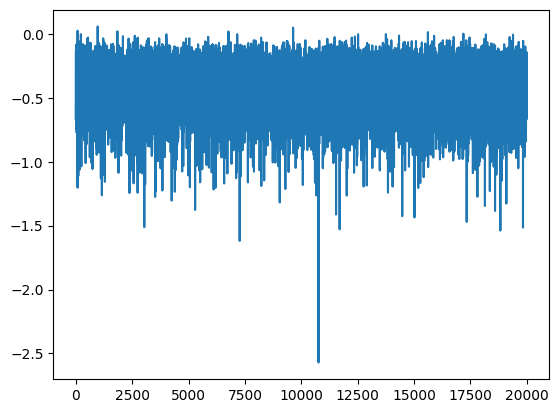

In [15]:
plt.plot(lossi)


In [12]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [13]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 0.4207233786582947
val 7.731078147888184
